# Assembly kmer estimates

We wish to the following properties of a genome based on the kmer histogram. Formally, we have as our input:

- $K_i$, where $i = 1..100001$, as the number of kmers at coverage $i$

We want to infer:

- $G_i$, where $i = 1..100$, as the number of kmers with copy number of $i$ in the genome sequence

This $G_i$ spectrum is interesting since it allows us to estimate

- Genome size $g = \sum_{i=1}^{100}{i * G_i}$

- Ploidy $p$ where $\sum_{i=1}^{p}{G_i} > 0.95 * \sum_{i=1}^{100}{G_i}$, i.e. with this ploidy you can explain most of the unique kmers in the genome

- Repeat contents $R = \sum_{i=p}^{100}{i * G_i} / \sum_{i=1}^{100}{i * G_i}$, ratio of all high copy kmers (larger than ploidy $p$) over all genome kmers

- Heterozygosity. Formula TBD.

$G_i$ can generate the expected $K_i$ which we can use to match to the observed $K_i$. The objective function can be minimize the K-L divergence.

- $D_{KL}(P | Q)$, where $P$ is the observed $K_i$ and $Q$ is the expected $K_i$, which is the amount of information lost when $Q$ is used to approximate $P$.

In [342]:
%matplotlib inline
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

## Sampling

In [94]:
from scipy.stats import nbinom
import numpy as np

In [293]:
def nbinom_pmf(x, lambda_, rho):
    n = lambda_ / (rho - 1)
    p = 1 / rho
    return nbinom.pmf(x, n, p)

def plot_negative_binomial(x, lambda_, rho=1.2, color='b'):
    y = nbinom_pmf(x, lambda_, rho)
    plt.plot(x, y, '-', color=color)
    return y

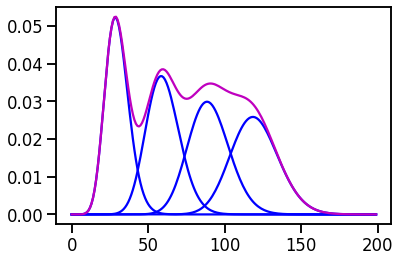

In [292]:
# Start multiple series at 30, 60, 90, 120
x = np.arange(200)
stacked_y = np.zeros(len(x))
for lambda_ in (30, 60, 90, 120):
    stacked_y += plot_negative_binomial(x, lambda_, rho=2, color='b')
plt.plot(x, stacked_y, "-", color='m')

In [132]:
# Read in real data
def parse_hist(filename="reads.histo"):
    hist = [0] * 10002
    with open(filename) as fp:
        for row in fp:
            cov, count = row.split()
            cov, count = int(cov), int(count)
            hist[cov] = count
    return np.array(hist)

hist = parse_hist()

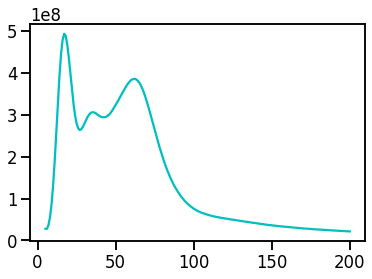

In [298]:
x = np.arange(5, 201, dtype=np.int)
y = hist[x] * x
plt.plot(x, y, "c-")

In [142]:
# Decompose the truncated histogram
X = np.arange(1, len(hist), dtype=np.int)
Y = hist[X] * X
total = Y.sum()
print(total)
print(y.sum())

46605857762
29574390523


In [340]:
from scipy.stats import entropy

coverage_range = np.arange(5, 201, dtype=np.int)
P = Y[coverage_range]

def generative_model(G, lambda_, rho):
    stacked = np.zeros(len(coverage_range), dtype=np.float64)
    n = lambda_ / (rho - 1)
    p = 1 / rho
    for i, g in enumerate(G):
        if 1 < g < 9e9:
            stacked += g * nbinom.pmf(coverage_range, n * (i + 1), p)
    stacked *= coverage_range
    return stacked

def func(lambda_, rho, G):
    stacked = generative_model(G, lambda_, rho)
    return np.sum((P - stacked) ** 2)

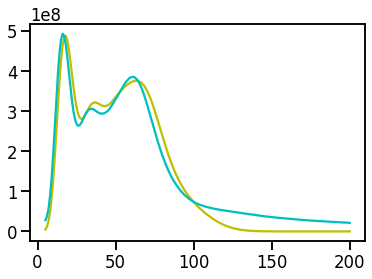

In [321]:
G = np.zeros(16)
G[0:6] = [3.7e8, 1.5e8, 1.1e8, 1.1e8, 2.5e7, 1e7]
lambda_ = 17
rho = 1.6
stacked = generative_model(G, lambda_, rho)
plt.plot(coverage_range, stacked, "y-")
plt.plot(coverage_range, P, "c-")

In [219]:
func(17, 1.5, G)

0.6431330311733933

## Optimizer

Optimize one variable at a time.

Instead of optimizing all $G_i$, we bin the larger values together, in geometrically sized bins. Within the bin, the value is presumed to be the same. A total of 22 bins.

- $G_1$ to $G_8$ (single copy to 8-copies) as usual
- $G_{9}$ to $G_{11}$, size 3
- $G_{12}$ to $G_{16}$, size 5
- $G_{17}$ to $G_{23}$, size 7
- $G_{24}$ to $G_{32}$, size 9
- $G_{33}$ to $G_{45}$, size 13
- $G_{46}$ to $G_{64}$, size 19
- $G_{65}$ to $G_{91}$, size 27
- $G_{92}$ to $G_{128}$, size 37
- $G_{129}$ to $G_{181}$, size 53
- $G_{182}$ to $G_{256}$, size 75
- $G_{257}$ to $G_{362}$, size 106
- $G_{363}$ to $G_{512}$, size 150
- $G_{513}$ to $G_{724}$, size 212
- $G_{725}$ to $G_{1024}$, size 300

In [350]:
bins = []
for i in range(1, 9):
    bins.append((i, i))
for i in (8, 16, 32, 64, 128, 256, 512):
    a, b = i + 1, int(round(i * 2 ** 0.5))
    bins.append((a, b))
    a, b = b + 1, i * 2
    bins.append((a, b))

print(bins)
# for a, b in bins:
#     print("- $G_{{{}}}$ to $G_{{{}}}$, size {}".format(a, b, b - a + 1))

[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 11), (12, 16), (17, 23), (24, 32), (33, 45), (46, 64), (65, 91), (92, 128), (129, 181), (182, 256), (257, 362), (363, 512), (513, 724), (725, 1024)]


In [356]:
from scipy.optimize import minimize_scalar
from functools import lru_cache

method, xopt = "bounded", "xatol"

@lru_cache(maxsize=None)
def nbinom_pmf_range(n, p, bin_id):
    stacked = np.zeros(len(coverage_range), dtype=np.float64)
    start, end = bins[bin_id]
    for i in range(start, end + 1):
        stacked += nbinom.pmf(coverage_range, n * i, p)
    return stacked

def generative_model(G, lambda_, rho):
    stacked = np.zeros(len(coverage_range), dtype=np.float64)
    n = lambda_ / (rho - 1)
    p = 1 / rho
    for i, g in enumerate(G):
        stacked += g * nbinom_pmf_range(n, p, i)
    stacked *= coverage_range
    return stacked

def func(lambda_, rho, G):
    stacked = generative_model(G, lambda_, rho)
    return np.sum((P - stacked) ** 2)

def optimize_func(lambda_, rho, G):
    # Iterate over all G
    for i, g in enumerate(G):
        optimize_func_Gi(lambda_, rho, G, i)
    lambda_ = optimize_func_lambda_(lambda_, rho, G)
    rho = optimize_func_rho(lambda_, rho, G)
    score = func(lambda_, rho, G)
    return lambda_, rho, G, score

def optimize_func_lambda_(lambda_, rho, G):
    def f(arg):
        return func(arg, rho, G)
    res = minimize_scalar(f, bounds=(5, 100), method=method, options={xopt: 0.01})
    return res.x

def optimize_func_rho(lambda_, rho, G):
    def f(arg):
        return func(lambda_, arg, G)    
    res = minimize_scalar(f, bounds=(1.001, 5), method=method, options={xopt: 0.01})
    return res.x

def optimize_func_Gi(lambda_, rho, G, i):
    # Iterate a single G_i
    def f(arg):
        G[i] = arg
        return func(lambda_, rho, G)
    minimize_scalar(f, bounds=(0, 1e10), method=method, options={xopt: 100})

G0 = np.zeros(len(bins))
l0 = 17
r0 = 1.6
print(l0, r0, G0)
def run_optimization():
    ll, rr, GG = l0, r0, G0
    prev_score = np.inf
    for i in range(10000):
        print("Iteration", i);
        ll, rr, GG, score = optimize_func(ll, rr, GG)
        if score / prev_score > 0.9999:
            break
        prev_score = score
        if i % 10 == 0:
            print(ll, rr, GG, score)
    print("Success!")
    # Remove bogus values that are close to 1e10
    GG = [(g if g < 9.9e9 else 0) for g in GG]
    return ll, rr, GG
        
ll, rr, GG = run_optimization()

17 1.6 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Iteration 0
16.23824780064023 1.7826910536740797 [4.10145071e+08 1.90405255e+08 1.62759470e+08 9.56909411e+07
 2.44633829e+07 1.39269592e+07 1.00781247e+07 7.12903917e+06
 2.84465885e+06 1.04602364e+06 5.97764872e+09 9.99999970e+09
 9.99999970e+09 9.99999970e+09 9.99999970e+09 9.99999970e+09
 9.99999970e+09 9.99999970e+09 9.99999970e+09 9.99999970e+09
 9.99999970e+09 9.99999970e+09] 4.788067495057931e+17
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
15.553795199755372 1.4896451087085758 [3.76101802e+08 1.42257721e+08 9.57555591e+07 1.18512956e+08
 3.33459113e+07 1.21643953e+07 7.41360798e+06 7.32655552e+06
 3.36686133e+06 1.30639498e+06 2.96906784e+08 1.91938445e+07
 9.99999970e+09 9.99999970e+09 9.99999970e+09 9.99999970e+09
 9.99999970e+09 9.99999970e+09 9.99999970e+09 9.99999970e+09
 9.99999970e+09 9.99999970e+09] 2957001931920633.5
It

In [357]:
genome_size = sum((i + 1) * g for i, g in enumerate(GG))
for i, g in enumerate(GG):
    print("Copy-{}: {} ({}%)".format(i + 1, g, (i + 1) * g * 100 / genome_size))

Copy-1: 375047126.65499806 (9.837321632419526%)
Copy-2: 142410686.6126406 (7.470739693952951%)
Copy-3: 96297967.8357776 (7.577560376995174%)
Copy-4: 116382936.63767812 (12.21069352474757%)
Copy-5: 36668340.16567135 (4.808972397067548%)
Copy-6: 11175959.924004696 (1.7588431614557993%)
Copy-7: 7923816.80409177 (1.4548676750948193%)
Copy-8: 7330345.468937997 (1.5381739718491714%)
Copy-9: 3352340.9465526324 (0.7913738938945055%)
Copy-10: 1417474.1762732125 (0.37179725924085266%)
Copy-11: 148758399.77101707 (42.92054336839271%)
Copy-12: 29416914.080008883 (9.259113044889386%)
Copy-13: 0 (0.0%)
Copy-14: 0 (0.0%)
Copy-15: 0 (0.0%)
Copy-16: 0 (0.0%)
Copy-17: 0 (0.0%)
Copy-18: 0 (0.0%)
Copy-19: 0 (0.0%)
Copy-20: 0 (0.0%)
Copy-21: 0 (0.0%)
Copy-22: 0 (0.0%)


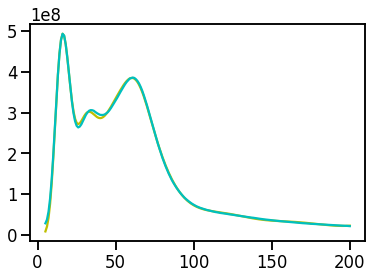

In [358]:
stacked = generative_model(GG, ll, rr)
plt.plot(coverage_range, stacked, "y-")
plt.plot(coverage_range, P, "c-")

In [327]:
# Optimize all variables at once
def optimize_func(lambda_, rho, G):
    def f(arg):
        g = np.array(arg[:-2], dtype=np.float64)
        l = arg[-2]
        r = arg[-1]
        if any(x < 0 for x in g):
            return np.inf
        if l <= 1:
            return np.inf
        if r <= 1:
            return np.inf
        return func(l, r, g)
    res = minimize(f, tuple(list(G) + [lambda_, rho]), method='nelder-mead')
    score = func(res.x[-2], res.x[-1], res.x[:-2])
    return res.x[-2], res.x[-1], res.x[:-2], score

G0 = np.ones(16)
l0 = 17
r0 = 1.6

print(l0, r0, G0)
def run_optimization(round):
    ll, rr, GG = l0, r0, G0
    for i in range(round):
        print("Iteration", i);
        ll, rr, GG, score = optimize_func(ll, rr, GG)
        print(ll, rr, GG, score)
        
run_optimization(10)

17 1.6 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Iteration 0
5.494310964329976 1.0919973352285304 [1.06101992 1.12914282 1.00002572 1.26510821 1.08946602 1.00000112
 1.11158054 1.11541641 1.08148784 1.06800824 1.00382618 1.18306524
 1.32743102 1.00000063 1.10276557 0.35976497] 8.277614013282319e+18
Iteration 1
5.665578024204201 1.094375731966334 [1.17812868e+00 1.21136296e+00 1.29554695e+00 1.31110330e+00
 1.42241367e+00 1.16358248e+00 1.00001316e+00 1.43430056e+00
 1.49517939e+00 1.00000304e+00 1.40629178e+00 1.56614123e+00
 1.00056621e+00 1.18411783e+00 1.00000025e+00 1.88786903e-06] 8.277613957158651e+18
Iteration 2
5.564181489867448 1.0000000504874837 [1.24557659e+00 1.00000341e+00 1.34124576e+00 1.00623726e+00
 1.26467132e+00 1.00046423e+00 1.16769721e+00 1.70042858e+00
 1.57527458e+00 1.34831008e+00 1.60387361e+00 1.92244218e+00
 1.20687501e+00 1.13188391e+00 1.16557496e+00 2.97162373e-09] 8.277613905638575e+18
Iteration 3
5.52620664056175 1.073717675549752 [8.31689248e-0

## Sequencing error and PCR duplicates (not used)

Assume we have a kmer that has a small error rate $\epsilon$ to generate an erroneous kmer when duplicating. We simulate 8 rounds of PCR.

In [88]:
from random import choice, random
from jcvi.formats.fasta import rc

def generate_kmer(K=21):
    s = ''.join([choice('ATCG') for x in range(K)])
    return min(s, rc(s))

def mutate_kmer(kmer, mu=0.01):
    s = ''.join([(choice('ATCG') if random() < mu else k) for k in kmer])
    return min(s, rc(s))

def evolve(kmer, mu=0.01, start_coverage=1, end_coverage=30):
    pool = [kmer] * max(start_coverage, 1)
    while len(pool) < end_coverage:
        pool += [mutate_kmer(kmer, mu=mu) for kmer in pool]
    return pool[:end_coverage]
        
def summarize(pool):
    from collections import Counter
    for k, v in Counter(pool).items():
        print(k, v)

In [9]:
starting_kmer = generate_kmer()
for i in range(10):
    dup_kmer = mutate_kmer(starting_kmer)
    if dup_kmer == starting_kmer:
        print(starting_kmer)
    else:
        print(starting_kmer, "=>", dup_kmer)

CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA => CTGCCCTGCTTTTATCCAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA
CTGCCCTGCTTTTATACAACA


In [70]:
pool = evolve(starting_kmer)
summarize(pool)

CTGCCCTGCTTTTATACAACA 27
CTCCCCTGCTTTTATACAACA 2
CTACCCTGCTTTTATACAACA 1


Now we have a mutation model which takes two parameters: 

- $\mu$ probability of per-base error when duplicating

- $r$ PCR duplication round, this is done with `start_coverage` and `end_coverage`

In [82]:
from functools import lru_cache
from collections import Counter
import sys

@lru_cache(maxsize=None)
def sequencing_model(K=21, mu1000x=10, rho100X=20, target_coverage=30):
    N = 10000
    diff = Counter()
    same = Counter()
    total = 0
    for _ in range(N):
        if i % 100 == 0: print("Sample", i, file=sys.stderr)
        starting_kmer = generate_kmer(K=K)
        pool = evolve(starting_kmer, mu=mu1000x/1000, 
                      start_coverage=target_coverage * rho100X // 100, 
                      end_coverage=target_coverage)
        for pkmer, v in Counter(pool).items():
            if pkmer == starting_kmer:
                same[v] += 1
            else:
                diff[v] += 1
            total += v
    return same, diff, total

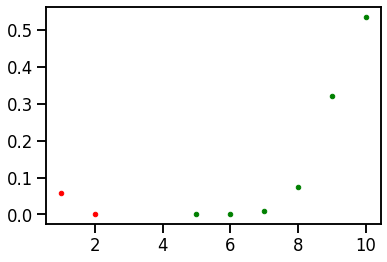

In [90]:
# rho100X is the diversity of starting material, 1 = 1% of the target coverage
mm_same, mm_diff, mm_total = sequencing_model(mu1000x=8, rho100X=50, target_coverage=10)

x, y = zip(*mm_same.items())
z = [_x * _y / mm_total for _x, _y in zip(x, y)]
plt.plot(x, z, ".", color='g')

x, y = zip(*mm_diff.items())
z = [_x * _y / mm_total for _x, _y in zip(x, y)]
plt.plot(x, z, ".", color='r')